# Tutorial: Evaluation of Galaxy Cluster Centering Models

Previously, we have mostly done simple, visual comparisons of fitted models or posterior predictions with data. In this notebook, we'll get more quantitative about saying whether a model could plausibly produce the observed data. Specifically, for a simple data set encoding the difference between 2 methods of defining a galaxy cluster's center, you will

* fit a simple model, visually compare the posterior to the data, and quantitatively compare posterior predictions of a test statistic with the data;
* propose a more complex model and repeat the same comparisons.

In [1]:
TutorialName = 'model_evaluation'
exec(open('tbc.py').read()) # define TBC and TBC_above
import numpy as np
import scipy.stats as st
import emcee
import incredible as cr
from pygtc import plotGTC
import matplotlib.pyplot as plt
%matplotlib inline

## The Dataset

Our data is just a list of numbers. Each one represents a measured distance, $y$, between two different estimates of the center of a galaxy cluster: the location of the presumed central galaxy and a centroid of the diffuse, emissive gas. The context here is that automated algorithms sometimes fail to chose the central galaxy correctly (because of image artifacts or other problems), whereas the gas centroid is more reliable but also more expensive to measure. Therefore, we'd like to use this data set to _characterize the distribution of mis-centerings_ so that the galaxy-based centers can be used for large sample, with the resulting errors propagated forward through future processing, e.g. weak lensing estimates.

Let's load up the data and have a look.

Load data into global variable `y`. Each entry is an offset in units of kpc. This particular data set is fictional, but intentionally similar to a real one that has actually been used for this purpose.

In [2]:
y = np.array([39.30917,35.13419,5.417072,59.75137,30.69077,14.45971,27.07368,27.48429,80.60219,483.1432,24.65057,
              22.36524,43.39081,39.89816,30.67409,6.905061,53.69709,9.504133,41.07874,10.9369,48.29861,61.34125,
              68.37279,30.51124,26.74462,13.7165,6.043301,976.1495,27.20097,7.818419,5.589193,3.310114,271.8901,
              126.0384,99.51247,249.1279,403.0484,3.071718,0.9434036,54.94336,1.529382,8.441071,19.59434,59.43049,
              77.21293,29.6533,286.7116,11.2386,9.511912,29.04711,33.77766,151.4803,223.3557,12.33816,25.22682,
              26.86597,339.7084,405.6737,3.809868,221.6523,307.2994,73.36697,42.15523,36.74785,5.415392,69.4721,
              136.8073,17.3534,4.135966,20.19435,79.06968,8.095599,4.474533,44.90669,85.891,1.636425,75.39335,
              15.94149,2.828709,20.5636,41.52905,42.51133,104.3908,67.41335,13.80204,394.9841,33.90415,84.78714,
              36.77924,14.48424,66.01276,2.910331,92.79938,29.74337,42.40971,1.692674,1.039994,120.5902,154.7106,
              14.38967,147.8399,166.5054,87.53685,22.63141,638.1976,273.6167,593.4997,45.57279,87.30421,75.03385,
              18.33932,36.05779,3.659462,263.9074,0.2432062,8.499095,1.160031,38.16615,41.65371,361.5,148.9294,
              10.25777,71.29159,10.02279,16.36062,601.1667,4.960311,12.22526,87.54137,48.48371,78.56777,212.8153,
              77.0353,62.7624,81.26739,34.36881,42.63432,264.4551,15.24863,25.94133,35.88882,34.94669,222.5425,
              304.9676,19.68377,7.216153,17.61534,32.25887,14.08842,773.5914])

Check out a quick histogram of the data.

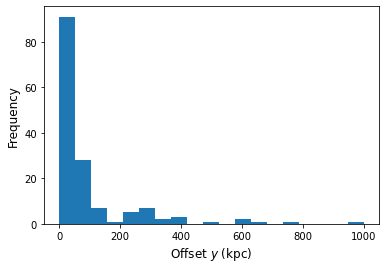

In [3]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)
bins = np.linspace(0,1000,20)
plt.hist(y, bins=bins);
plt.xlabel("Offset $y$ (kpc)", fontsize=12);
plt.ylabel("Frequency", fontsize=12);

## 1. Choosing a Test Statistic

The model we will test in this tutorial is outlined in the next section - but how well that model fits the data is a question we will answer in part using a _test statistic._ 

In this case, a feature we especially want to capture with our model is the fraction of clusters where $y$ is small (in the context of a galaxy cluster) vs not small. For concreteness, in the work you turn in, make $T$ the number of clusters with $y<100$ kpc. However, you are encouraged to play around with other possibilities to see how the simple model below succeeds or fails to reproduce the corresponding features of the data.

Below, define a function that computes this test statistic.

In [7]:
def T(yy):
    ct=0
    for y in yy:
        if y<100:
            ct+=1
    return ct

Compute the test statistic of the real data to verify that it works.

In [8]:
T_true = T(y)
print("The test statistic of the real data is T =", T_true)

The test statistic of the real data is T = 118


**Self-check:** The recommended test statistic evaluates to 118 on the real data.

## Setting up a Computational Framework

Once we define a model to work with (below), we'll want to fit that model to the data, and then evaluate it using the methods we saw in the [notes](../notes/model_evaluation.ipynb). These include:

* a visual check using replica datasets drawn from the posterior predictive distribution
* a quantitative posterior predictive model check using a suitable test statistic $T(y)$

In the next notebook, we'll choose and fit a second, alternative model, and compare the two in terms of

* the Deviance Information Criterion (DIC), to assess the models' (relative) generalized predictive accuracy
* the Bayesian Evidence, to provide insight on the (relative) probability of each model given the data

Notice that each of these bulleted operations can be coded as a _function of the model_, $H$ (e.g. a visual check of the model, the evidence of the model, and so on). We will therefore be fancy and write a class that completely describes the model, and also contains a set of functions that act on model (methods). Since we anticipate looking at multiple models, we'll use inheritance. While this level of object oriented programming may not be familiar, it's a good thing to learn, and most of the details are filled in for you below.

We start by defining a base class, which contains the functionality common to any model we care to define later. To make it clear what functionality we expect derived classes to provide, we'll include defintions of non-functional methods that the derived classes will need to override. (This is completely unnecessary in Python, but has the benefit of providing a complete list of functions we'll eventually want to fill in.)

The functions that are filled in below (towards the bottom) are the ones that we won't need to modify for any particular model. Do take a moment to make sure you understand how they work; they are mostly doing things you've seen before. Wherever you see `**params` here, a derived class would have a specific list of arguments corresponding to the model parameters.

In [25]:
# This is something we can throw to discourage direct instantiation of the base class
class VirtualClassError(Exception):
    def __init__(self):
        Exception.__init__(self,"Do not directly instantiate the base Model class!")

class Model:
    """
    Base class for inference and model evaluation in a simple cluster mis-centering analysis.
    In all these functions, `params' is a dictionary of model parameters.
    """
    def __init__(self, samples=None):
        """
        Note: derived classes should have their own __init__ function which ends by calling this one
        """
        # Storage for MCMC samples from fitting the model
        self.samples = samples
        if samples is None:
            self.Nsamples = 0
        else:
            self.Nsamples = samples.shape[0]
        # Lines below are meant as a template for derived classes, do not uncomment for the base class
        #
        # A name for the model!
        #self.name = '...'
        #
        # As part of the model definition, store an ordered list of parameter names (for dictionary keys)
        # Named arguments of other functions that correspond to parameters should appear in this order
        #self.param_names = [...]
        #
        # parameter names as display text (for plot labels),
        #self.param_labels = [...]
        #
        # and a dictionary of priors (keys must match param_names)
        #   (we like to use frozen scipy.stats distribution objects for this, but you'll be implementing the log_prior
        #    function below, so really the dictionary entry could be anything that specifies the prior)
        #self.priors = {...}
        #
        # The next line finishes initialization by calling the parent class' __init__
        #Model.__init__(self, samples)
  
    def log_prior(self, **params):
        """
        Return the log prior PDF p(params|H)
        """
        raise VirtualClassError # to be overriden by child classes

    def draw_samples_from_prior(self, N):
        """
        Return N samples from the prior PDF p(params|H) as a list of dictionaries
        """
        raise VirtualClassError # to be overriden by child classes

    def log_likelihood(self, **params):
        """
        Return the log of the likelihood function L(params) = p(y|params,H)
        """
        raise VirtualClassError # to be overriden by child classes
    
    def sampling_distribution(self, yy, **params):
        """
        Return the sampling distribution p(yy|params,H) at a point in data space yy given parameter(s) args
        We expect a vector input yy, and return the corresponding probabilities.
            
        Note: This is useful for making plots of "the model" overlaid on the histogram of the data
        """
        raise VirtualClassError # to be overriden by child classes 
        
    def generate_replica_dataset(self, N, **params):
        """
        Return a replica dataset y_rep of length N from the sampling distribution p(y_rep|args,H).
        """
        raise VirtualClassError # to be overriden by child classes
        
    def log_posterior(self, parameterlist=None, **params):
        """
        Return the log of the (unnormalized) posterior PDF p(params|y,H)
        
        The parameterlist argument is there for compatibility with emcee.
        This will be an infinite loop if you named one of your parameters "parameterlist", but in that case
        you deserve it.
        This also means that for even a simple call, we would need to specify the parameter name(s),
         i.e. not log_posterior(pval), but log_posterior(param=pval). This doesn't seem unreasonable.
        """
        if parameterlist is not None:
            pdict = {k:parameterlist[i] for i,k in enumerate(self.param_names)}
            return self.log_posterior(**pdict)
        lnp = self.log_prior(**params)
        print(lnp)
        if lnp != -np.inf:
            lnp += self.log_likelihood(**params)
        return lnp

    def draw_samples_from_posterior(self, starting_params, nsteps, nwalkers=8, threads=1):
        """
        Use emcee to draw samples from P(params|y,H). Hopefully it Just Works.
        You could try using e.g. threads=4 to speed things up with multiprocessing.
        """
      
        # The density to sample is this model's own posterior PDF
        npars = len(starting_params)        
        self.sampler = emcee.EnsembleSampler(nwalkers, npars, self.log_posterior, threads=threads) 
        
        # Generate an ensemble of walkers within +/-1% of the guess:
        theta_0 = np.array([starting_params*(1.0 + 0.01*np.random.randn(npars)) for j in range(nwalkers)])
        # Note that the initial parameter array theta_0 should have dimensions nwalkers x npars
        
        # Evolve the ensemble:
        self.sampler.run_mcmc(theta_0, nsteps)
        
        # Plot the raw samples:
        plt.rcParams['figure.figsize'] = (12.0, 4.0*npars)
        fig, ax = plt.subplots(npars, 1);
        cr.plot_traces(self.sampler.chain[:min(8,nwalkers),:,:], ax, labels=self.param_labels);

    def check_chains(self, burn, maxlag):
        '''
        Ignoring `burn` samples from the front of each chain, compute convergence criteria and
        effective number of samples.
        '''
        nwalk, nsteps, npars = self.sampler.chain.shape
        if burn < 1 or burn >= nsteps:
            return
        tmp_samples = [self.sampler.chain[i,burn:,:] for i in range(nwalk)]
        print('R =', cr.GelmanRubinR(tmp_samples))
        print('neff =', cr.effective_samples(tmp_samples, maxlag=maxlag))
        print('NB: Since walkers are not independent, these will be optimistic!')

    def remove_burnin(self, burn):
        '''
        Remove `burn` samples from the front of each chain, and concatenate
        Plot, and store the result in self.samples
        '''
        nwalk, nsteps, npars = self.sampler.chain.shape
        if burn < 1 or burn >= nsteps:
            return
        self.samples = self.sampler.chain[:,burn:,:].reshape(nwalk*(nsteps-burn), npars)
        self.Nsamples = self.samples.shape[0]
        plt.rcParams['figure.figsize'] = (12.0, 4.0*npars)
        fig, ax = plt.subplots(npars, 1);
        cr.plot_traces(self.samples, ax, labels=self.param_labels);
        
    def posterior_mean(self):
        '''
        Helper function for computing the posterior mean of each parameter (from MCMC samples)
        '''
        m = np.mean(self.samples, axis=0)
        return {k:m[i] for i,k in enumerate(self.param_names)}

## 2. Evaluating a Simple Model

First, let's assume the simple model $H_1$, that the sampling distribution is an exponential:

$p(\{y_i\}|a, H_1) = \prod_i \frac{1}{a}e^{-y_i/a}$; $y_i\geq0$

Our single parameter is $a$, the mean of the exponential distribution.

Note that this is the entirety of the sampling distribution. Don't be scared of the simplicity! Our model is that the data are realizations of some distribution, and we want (initially) to find the parameter(s) of that distribution. There's nothing tricky (but also nothing Gaussian) about this.

### 2a. Implementation in code

Complete the implementation of this model as a derived class of `Model`, below. An `ExponentialModel` object will still have all the methods defined for `Model`, in particular the ones that are not redefined (overriden) here.

Note that this includes choosing a reasonable prior for $a$. It should be a proper (normalizable) distribution. We don't want to deal with improper distributions when calculating the evidence later on. _To compare with the self-check below, use a wide, uniform (but bounded!) prior_. If you need to get some intuition for what constitutes a "wide" prior compared with what the posterior is likely to allow, try plotting some example curves over the histogram of the data. Below, state your prior for $a$ for the record.

a~Uniform(0.1,100)

Look for the magic work "TBC" to find functions that need to be completed. Again, even when a function below is completely given, you should make sure you understand how it works.

In [55]:
class ExponentialModel(Model):
    """
    Simple exponential model for mis-centering.
    """
    def __init__(self, *args, **kwargs):
        # As part of the model definition, store an ordered list of parameter names (for dictionary keys)
        # A name for the model!
        self.name = 'Exponential Model'
        # Named arguments of other functions that correspond to parameters should appear in this order
        self.param_names = ['a']
        # parameter names as display text (for plot labels),
        self.param_labels = [r'$a$']
        # and a dictionary of priors (keys must match param_names)
        #   (we like to use frozen scipy.stats distribution objects for this, but you'll be implementing the log_prior
        #    function below, so really the dictionary entry could be anything that specifies the prior)
        self.priors = {'a':st.uniform()}
        # The next line finishes initialization by calling the parent class' __init__
        Model.__init__(self, *args, **kwargs)
  
    def log_prior(self, a):
            
            """
            Return the log prior PDF P(a1|H)
            """
            rv = st.uniform(loc=0.1,scale=100)
            return rv.logpdf(a)

    def draw_samples_from_prior(self, N):
        """
        Return N samples of a from the prior PDF p(a|H) as a 2D array
        (one column per parameter)
        """
        res=[]
        for i in range(N):
            a=st.uniform.rvs(loc=0.1,scale=100)
            y=st.expon.rvs(a)
            res.append([a,y])
        return np.array(res)
    def log_likelihood(self, a):
        """
        Evaluate the log of the likelihood function L(a) = p(y|a,H)
        """
        return np.sum(st.expon.logpdf(y, scale=a))
    
    def sampling_distribution(self, yy, a):
        """
        Evaluate the sampling distribution PDF p(yy|a,H) at a point in data space yy given parameter value a
        We expect a vector input yy, and return the corresponding probabilities.
            
        Note: This is useful for making plots of "the model" overlaid on the histogram of the data
        """
        return st.expon.pdf(yy, scale=a)
        
    def generate_replica_dataset(self, N, a):
        """
        Return a replica data set y_rep of length N from the sampling distribution p(y_rep|a,H).
        """
        res=[]
        for i in range(N):
            y=st.expon(scale=a).rvs()
            res.append(y)
        return np.array(res)

Now try instantiating a model and drawing a dozen samples from its prior as a test:

In [56]:
Model1 = ExponentialModel()
print("12 sample values drawn from the prior of Model1: ", Model1.draw_samples_from_prior(12))

12 sample values drawn from the prior of Model1:  [[88.60677348 88.8388316 ]
 [67.51300108 68.84765808]
 [39.50825759 39.64818659]
 [37.14592357 38.40591927]
 [54.39327436 54.57223799]
 [86.41355158 86.63371866]
 [55.80189818 56.57250513]
 [52.84120246 53.02556388]
 [57.01938684 57.7034684 ]
 [95.50790508 95.78792002]
 [80.15381146 82.26826114]
 [80.69267031 82.1282574 ]]


Test out the log-posterior function to make sure it's not obviously buggy.

In [58]:
for a in [1.0, 10.0, 100.0, -3.14]:
    print('Log-posterior for a=', a, ' = ', Model1.log_posterior(a=a))

-4.605170185988092
Log-posterior for a= 1.0  =  -14243.396648985989
-4.605170185988092
Log-posterior for a= 10.0  =  -1773.8720820150952
-4.605170185988092
Log-posterior for a= 100.0  =  -837.7686128722019
-inf
Log-posterior for a= -3.14  =  -inf


Similarly the mock-data producing function (arbitrarily with $a=500$).

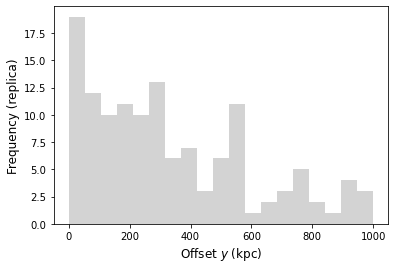

In [59]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.hist(Model1.generate_replica_dataset(N=len(y), a=500.), bins=bins, color="lightgray");
plt.xlabel("Offset $y$ (kpc)", fontsize=12);
plt.ylabel("Frequency (replica)", fontsize=12);

Finally, test the sampling distribution function.

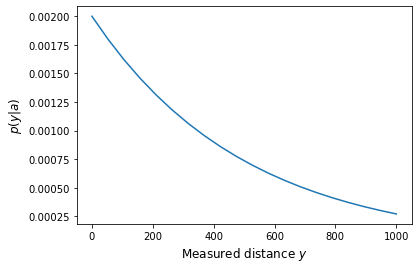

In [60]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.plot(bins, Model1.sampling_distribution(bins, a=500.));
plt.xlabel("Measured distance $y$", fontsize=12);
plt.ylabel("$p(y|a)$", fontsize=12);

### 2b. Fit the model to the data

The `draw_samples_from_posterior` method carries out a parameter inference with `emcee` and displays its Markov chains. `remove_burnin` removes burn-in and concatenates the chains. Since these step aren't really the point of this problem, we'll just give you the code... for this model. Keep in mind that you're going to choose the alternative model to consider below, so we can't say what values of the keyword arguments used below will be appropriate for that case. Best not to speed through this section without looking at and thinking about what's happening, in other words.

The concatenated MCMC samples are eventually stored in the `Model1.samples` array.

-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-inf
-inf
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4

/home/ohj/.local/lib/python3.10/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]



-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-

-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-

-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092


-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.60

-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.60517018

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051701859880

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051701859880

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051701859880

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.6051701859880

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051

-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051701859880

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.6051701859880

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.60

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.60517018

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.60517018

-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051701

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605

-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.60517018

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051701859880

-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-inf


-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-

-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605

-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185

-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051701859880

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.60517018

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.6051701859880

-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051701

-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-

-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092


-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051701859880

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051

-inf
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.60

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4

-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.6051701

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.6051701859880

-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.60517018598

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.60517018

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.60517018

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-

-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4

-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-inf
-4.605170185988092
-4.605170185988092
-4.60

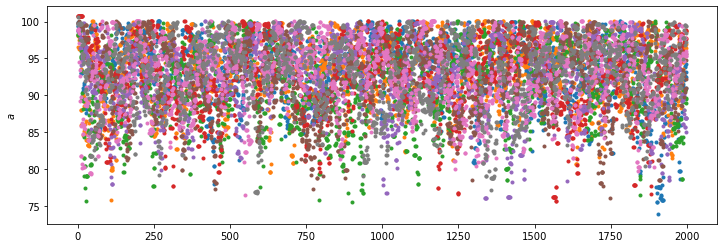

In [61]:
%%time
Model1.draw_samples_from_posterior(starting_params=[100.0], nsteps=2000, nwalkers=16)

This will compute the usual convergence criteria and effective number of samples:

In [62]:
Model1.check_chains(burn=200, maxlag=200)

R = [1.0065621]
neff = [993.97833859]
NB: Since walkers are not independent, these will be optimistic!


Assuming that looks ok, remove the burn-in for good, and plot the concatenation of what's left.

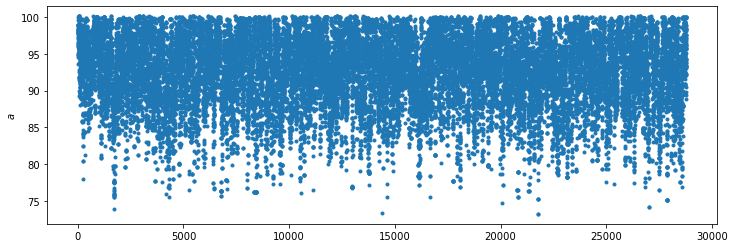

In [63]:
Model1.remove_burnin(burn=200)

It will be useful for later to know the mean of the posterior:

In [64]:
print("Posterior mean:", Model1.posterior_mean())

Posterior mean: {'a': 92.59448926943993}


**Checkpoint:** With wide, uniform priors, you should find a posterior mean $a$ of around 96.

### 2c. Visually compare the posterior predictions with the data.

First, let's just plot the posterior-mean model over the data.

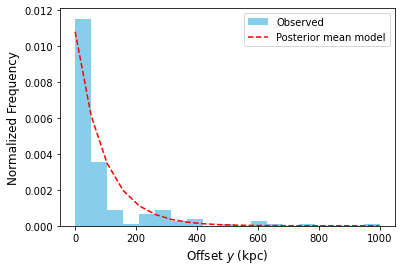

In [65]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)

# First the histogram of observed data, as backdrop:
plt.hist(y, bins=bins, color="skyblue", density=True, label="Observed")

# Now overlay a curve following the sampling distribution conditioned on the posterior mean value of a1: 
pp = Model1.sampling_distribution(bins, **Model1.posterior_mean())
plt.plot(bins, pp, linestyle="dashed", color="red", label="Posterior mean model")

plt.xlabel("Offset $y$ (kpc)", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)
plt.legend();

This kind of plot should be familiar: it's often a good idea to evaluate model adequacy in data space. You should already be able to see telling differences between the a well-fitting model's sampling distribution, and the data histogram. However, we don't know to what extent those could be explained simply by the variability in the sampling distribution, let along the posterior uncertainty in $a$.

So, next, let's compare a random predicted ("replica") data set, drawn from the posterior predictive distribution, with the data. To do this we first draw a parameter value from the posterior PDF, and then generate a dataset from the sampling distribution conditioned on that value. The result is a sample from $p(y_\mathrm{rep}|y,H_1)$.

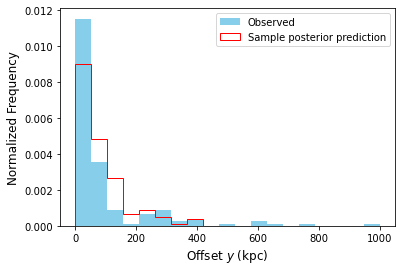

In [66]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)

# First the histogram of observed data, as backdrop:
plt.hist(y, bins=bins, color="skyblue", density=True, label="Observed");

# Choose a posterior sample at random and generate a replica dataset, and show its histogram
j = np.random.randint(0, Model1.Nsamples)
mock = Model1.generate_replica_dataset(len(y), *Model1.samples[j,:])
plt.hist(mock, bins=bins, alpha=1.0, histtype="step", color="red", density=True, label="Sample posterior prediction")

plt.xlabel("Offset $y$ (kpc)", fontsize=12)
plt.ylabel("Normalized Frequency", fontsize=12)
plt.legend();

This plot is nice because it is comparing apples with apples, asking: do mock datasets drawn from our model sampling distribution with any plausible parameter value "look like" the real data?

However, to best evaluate this, we want to visualize the posterior predictive distribution of replica datasets instead of looking at just one. We can do this by plotting many replica datasets drawn from the posterior predictive PDF. Let's put this plot in a function, so we can re-use it later.

In [67]:
def visual_check(axes, Model, Nreps=None):
    # First the histogram of observed data, as backdrop:
    axes.hist(y, bins=bins, color="skyblue", density=True, label="Observed");

    # Compute the posterior mean parameters
    pm = Model.posterior_mean()

    # Make a large number of replica datasets, and overlay histograms of them all 
    if Nreps is None: Nreps = len(Model.samples)
    alpha = 5.0 / Nreps
    for jj in np.round(np.linspace(0, len(Model.samples), num=Nreps, endpoint=False)): 
        j = int(jj)
        if j==0:  
            # Plot a dataset drawn from the posterior mean, to give a good legend
            mock = Model.generate_replica_dataset(len(y), **pm)
            axes.hist(mock, bins=bins, histtype="step", alpha=1.0, color="red", density=True,
                     label="Sample posterior predictions");
        else:     
            # Take the next posterior sample a and generate a replica dataset
            mock = Model.generate_replica_dataset(len(y), *Model.samples[j,:])
            axes.hist(mock, bins=bins, histtype="step", alpha=alpha, color="red", density=True);

    # Include the posterior mean model for comparison
    pp = Model.sampling_distribution(bins, **pm)
    axes.plot(bins, pp, linestyle="dashed", color="red", label="Posterior mean model");

    axes.set_title(Model.name, fontsize=14)
    axes.set_xlabel("Offset $y$ (kpc)", fontsize=12)
    axes.set_ylabel("Normalized Frequency", fontsize=12)
    axes.legend();

The use of transparency above means that the darkness of the red histogram lines below corresponds to the PPD at that offset.

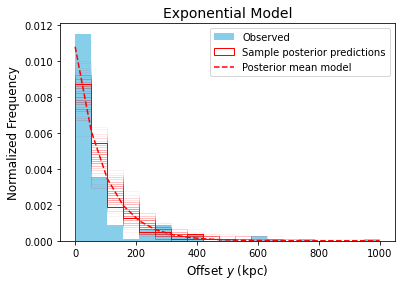

In [68]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)
fig, ax = plt.subplots(1)
visual_check(ax, Model1, Nreps=100);

Based on these visual checks, would you say the model does a good job of predicting the observed data?

YES

### 2c. Quantitative posterior predictive model check

Now let's quantify the (in)adequacy of the fit with a quantitative posterior predictive model check, based on the `test_statistic` function you've already defined.

To sample the posterior predictive distribution of test statistics $p[T(y_\mathrm{rep})|y,H]$, we need to generate replica datasets from the model:

In [69]:
def distribution_of_T(Model):
    """
    Compute T(yrep) for each yrep drawn from the posterior predictive distribution,
    using parameter samples stored in Model.
    """
    return np.array([T(Model.generate_replica_dataset(len(y), *p)) for p in Model.samples])

We can now do the following:
* plot a histogram of $T(\mathrm{mock~data})$
* compare that distribution with $T(\mathrm{real~data})$
* compute and report the p-value for $T(\mathrm{real~data})$

And we want all of that in packaged in functions of the model, so that we can re-use it later (on different models!). 

First write a function to estimate the p-value, $P(T > T(y)|y,H)$, based on posterior predictions from the chains you ran above.

In [82]:
def pvalue(Model):
    j = np.random.randint(0, Model.Nsamples)
    mock = Model.generate_replica_dataset(len(y), *Model.samples[j,:])
    N=len(y)
    chisq_min=sum((mock-y)**2)
    chisq_min
    chisq = st.chi2(N)
    pvalue = chisq.sf(chisq_min)
    return pvalue

Here's a function that plots the distribution of T, and reports the p-value:

In [83]:
def posterior_predictive_check(Model, nbins=25):
    """
    Compute the posterior predictive distribution of the test statistic T(y_rep), and compare with T(y_obs) 
    """
    # Compute distribution of T(yrep):
    TT = distribution_of_T(Model)
    
    # Plot:
    plt.rcParams['figure.figsize'] = (7.0, 5.0)
    plt.hist(TT, bins=nbins, histtype="step", color="red", label="$P(T(y_{\\rm rep})|y)$")
    
    # Overlay T(y_obs):
    plt.axvline(x=T(y), color="gray", linestyle="dashed", label="$T(y_{\\rm observed})$")
    plt.xlabel("Test statistic T(y)", fontsize=12)
    plt.ylabel("Posterior predictive probability density", fontsize=12)
    plt.legend();
    
    # Compute p-value:
    p = pvalue(Model)
    print("p-value =", p)

    return p

Let's see how it does:

In [86]:
p1 = pvalue(Model1)
p1

0.0

**Checkpoint:** If you implemented the test statistic and priors recommended above, your p-value should be about 0.001. The precise value will vary because of all the randomization involved in estimating it, and the fact that we are out in the tail of the posterior predictive distribution.

## 3. Evaluating a more complex model

Next, we'll repeat all of that (it should be much easier this time!) with a second model. The functional form is up to you, but to make things interesting, choose a model with at least two parameters. Since this is a PDF over distances, it should be defined over the non-negative real line. The test statistic will, of course, have to be the same as before.

Put some thought into the priors for this model. They will be important when we come to comparing the two models quantitatively in the next notebook.

Copy/paste your implementation of `ExponentialModel` and edit it to implement some other model (give the class a different name, naturally).

In [92]:
class LomaxModel(Model):
    """
    Simple exponential model for mis-centering.
    """
    def __init__(self, *args, **kwargs):
        # As part of the model definition, store an ordered list of parameter names (for dictionary keys)
        # A name for the model!
        self.name = 'Lomax Model'
        # Named arguments of other functions that correspond to parameters should appear in this order
        self.param_names = ['a']
        # parameter names as display text (for plot labels),
        self.param_labels = [r'$a$']
        # and a dictionary of priors (keys must match param_names)
        #   (we like to use frozen scipy.stats distribution objects for this, but you'll be implementing the log_prior
        #    function below, so really the dictionary entry could be anything that specifies the prior)
        self.priors = {'a':st.uniform()}
        # The next line finishes initialization by calling the parent class' __init__
        Model.__init__(self, *args, **kwargs)
  
    def log_prior(self, a):
            
            """
            Return the log prior PDF P(a1|H)
            """
            rv = st.uniform(loc=0.1,scale=140)
            return rv.logpdf(a)

    def draw_samples_from_prior(self, N):
        """
        Return N samples of a from the prior PDF p(a|H) as a 2D array
        (one column per parameter)
        """
        res=[]
        for i in range(N):
            a=st.uniform.rvs(loc=0.1,scale=100)
            y=st.lomax.rvs(a)
            res.append([a,y])
        return np.array(res)
    def log_likelihood(self, a):
        """
        Evaluate the log of the likelihood function L(a) = p(y|a,H)
        """
        return np.sum(st.lomax.logpdf(y, a))
    
    def sampling_distribution(self, yy, a):
        """
        Evaluate the sampling distribution PDF p(yy|a,H) at a point in data space yy given parameter value a
        We expect a vector input yy, and return the corresponding probabilities.
            
        Note: This is useful for making plots of "the model" overlaid on the histogram of the data
        """
        return st.lomax.pdf(yy, a)
        
    def generate_replica_dataset(self, N, a):
        """
        Return a replica data set y_rep of length N from the sampling distribution p(y_rep|a,H).
        """
        res=[]
        for i in range(N):
            y=st.lomax(a).rvs()
            res.append(y)
        return np.array(res)## Instantiate it:
Model2 = LomaxModel() # replace with the actual name of your new class

Test the prior sampling function:

In [93]:
for pars in Model2.draw_samples_from_prior(12):
    print(pars)

[1.80264647e+01 4.21824039e-03]
[7.99876847e+01 2.39959500e-03]
[4.71192497e+01 1.15301891e-03]
[8.13156498e+01 8.85618203e-04]
[3.45510778e+01 1.79025428e-04]
[8.65360639e+01 3.90871889e-03]
[6.70183175e+01 9.89938059e-03]
[2.41340564e+01 2.05886295e-03]
[5.48284144e+01 4.03075275e-04]
[9.28112503e+01 1.80214097e-02]
[5.23555264e+01 4.98894928e-02]
[9.18201852 0.15717556]


Test the posterior function on a couple of these prior samples:

In [94]:
Model2.draw_samples_from_prior(5)

array([[1.24765759e+01, 4.06830408e-02],
       [3.98569154e+01, 2.31338741e-02],
       [4.04464552e+01, 1.74065941e-02],
       [6.84857065e+01, 8.59367892e-03],
       [5.60217053e+01, 3.01039831e-02]])

In [95]:
for a in [1.0, 10.0, 100.0, -3.14]:
    print('Log-posterior for a=', a, ' = ', Model2.log_posterior(a=a))

-4.941642422609304
Log-posterior for a= 1.0  =  -1099.4261345177022
-4.941642422609304
Log-posterior for a= 10.0  =  -5679.218584996514
-4.941642422609304
Log-posterior for a= 100.0  =  -54585.6329653266
-inf
Log-posterior for a= -3.14  =  -inf


Test the mock data generator. Here and in the following test, you can replace the call to `draw_samples_from_prior` with specific parameter values if your prior is so wide that you're unlikely to see anything on the plot.

In [99]:
Model2.draw_samples_from_prior(1)[0][0]

20.013340769120326

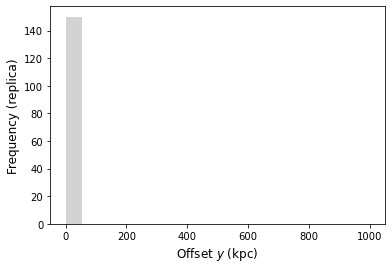

In [100]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.hist(Model2.generate_replica_dataset(len(y), Model2.draw_samples_from_prior(1)[0][0]), bins=bins, color="lightgray");
plt.xlabel("Offset $y$ (kpc)", fontsize=12);
plt.ylabel("Frequency (replica)", fontsize=12);

Test the sampling distribution.

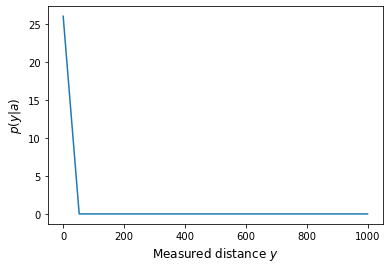

In [102]:
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.plot(bins, Model2.sampling_distribution(bins, Model2.draw_samples_from_prior(1)[0][0]));
plt.xlabel("Measured distance $y$", fontsize=12);
plt.ylabel("$p(y|a)$", fontsize=12);

Fit the model. Remember that a thoughtless copy/paste of the corresponding Model1 lines above will not work!

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-inf
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-inf
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-inf
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.9416424226093

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-inf
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-inf
-inf
-inf
-inf
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-inf
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-inf
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-inf
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-inf
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.94

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-inf
-4.941642422609304
-inf
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422609304
-4.941642422

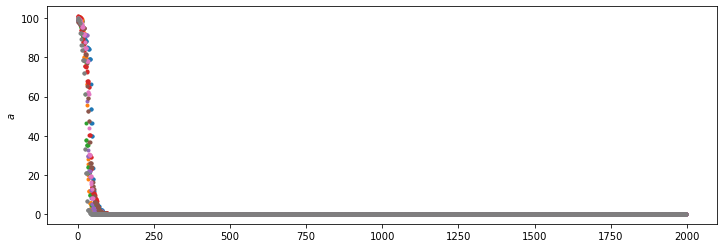

In [104]:
%%time
Model2.draw_samples_from_posterior(starting_params=[100.0], nsteps=2000, nwalkers=16)

Check the convergence

In [105]:
Model2.check_chains(burn=200, maxlag=200)

R = [1.00621612]
neff = [958.85043182]
NB: Since walkers are not independent, these will be optimistic!


Remove burn-in.

In [ ]:
TBC() # Model2.remove_burnin( ...

Since we have multiple parameters this time around, let's look at their covariances. (The size below is good for 2 parameters, but increase it as needed.)

In [ ]:
plotGTC(Model2.samples, paramNames=Model2.param_labels, figureSize=6,
        customLabelFont={'size':12}, customTickFont={'size':12}, customLegendFont={'size':16});

Print the posterior mean.

In [ ]:
print("Posterior mean parameters = ", Model2.posterior_mean())

Visually compare posterior predictions with the data, alongside those of the exponential model.

In [ ]:
plt.rcParams['figure.figsize'] = (14.0, 5.0)
fig, ax = plt.subplots(1,2)
visual_check(ax[0], Model1, Nreps=100);
visual_check(ax[1], Model2, Nreps=100);

Finally, compute the p-value.

In [ ]:
p2 = posterior_predictive_check(Model2)

Does your model appear to reproduce the data better than the exponential one? Does it have a "better" p-value?

In [ ]:
TBC() # answer in Markdown

So is it a better model, in the sense of being justified by the data? To answer that, we need to keep in mind that a more flexible model (i.e. with more free parameters) will usually be able to fit the data more closely, even if it's only reproducing the particular realization of noise present in our specific data set. In other words, directly comparing the maximum likelihood achieved, or even the p-values, is not enough to say that the more complex model is statistically better at reproducing the features of the observed data. For that, we will need to turn from model evaluation to model comparison. We'll be re-using the chains for both models, so save them below.

In [ ]:
np.savetxt('saved/centering_model1_chain.txt', Model1.samples)
np.savetxt('saved/centering_model2_chain.txt', Model2.samples)